# Demo extraction of a connectivity matrix from an ECR results file
1. Extract the matrix from an ECR results pickle file
2. "Correct the matrix by removing connections that are likely incorrect

In [1]:
import numpy as np
import pickle as pkl
from pprint import pprint
import os
import matplotlib
import matplotlib.pyplot as plt
import glob
plt.ion()

In [2]:

# Path of source .pkl result files
path_source_files = '/cis/project/organoid/Dec_29_2024_ecr_results'


# Get a list of files that we'll analyze (pkl files in the source directory or its subdirectories)
filenames = glob.glob(f'{path_source_files}/**/*.pkl', recursive=True)
n_chars = len(path_source_files)
filenames = [f[n_chars:] for f in filenames]
filenames.sort()
filenames.reverse()

print(f'Found {len(filenames)} pkl files to process.')

filenames = [f[1:] if f.startswith('/') else f for f in filenames]
print(filenames)

Found 1 pkl files to process.
['M07915/Stimulation/000295/data.raw_20241213_18h15m.pkl']


## Load Effective Connecivity Reconstruction (ECR) data from a pickle file

In [3]:
all_data = {}
for filename in filenames:
    src_filename = os.path.join(path_source_files, filename)
    with open(src_filename, 'rb') as f:
        all_data[filename] = pkl.load(f)

In [9]:
for filename in filenames:
    data = all_data[filename]
    spike_amp_thresh_percentile = data['config']['data']['spike_amp_thresh_percentile']
    adj_threshold = data['config']['super_sel']['adj_threshold']
    raster_dur = data['config']['super_sel']['raster_dur']
    epsilon = data['config']['super_sel']['epsilon']
    edges = sum(sum(data['well005']['win_0']['adj_matrix_predicted']))
    print(f'For spike_amp_thresh_percentile as {spike_amp_thresh_percentile} and adj_threshold as {adj_threshold} and raster_dur as {raster_dur}, the edges number is: {edges}')

For spike_amp_thresh_percentile as 3.25 and adj_threshold as 0.5 and raster_dur as 0.0005, the edges number is: 69571


np.int64(384410)

## Show some of the keys in the hierarchical dictionary

In [9]:
print(data.keys())
print(data['well000'].keys())
print(data['well000']['win_0'].keys())

dict_keys(['source_filename', 'config', 'well001'])


KeyError: 'well000'

## View time periods over which ECR matrices were computed

Duration of windows and their overlap is given in the 'config' section of the data dict. If the window duration is `None` then the full duration of the recording was used to compute connectivity over a single "window."

In [4]:
print(data['config']['windows'])

{'win_dur': 'None', 'win_overlap_dur': 30}


## Data description

For each well (organoid) and time window, there are three key/value pairs. For matrix values, the first dimension is the ID of the presynaptic neuron and the second dimension is that of the postsynaptic neuron.

1. `votes`: The votes matrix. votes[i, j] is the fraction of trials in which a directed connection was predicted to exist from neuron i to neuron j.
2. `adj_matrix_predicted`: The predicted adjacency matrix. This is a Boolean matrix where adj_matrix_predicted[i, j]==True indicates that votes[i, j]==1.
3. `corr_peaks`: corr_peaks is a dict with keys of the form (i, j). corr_peaks[(i, j)] is a dict with lists `amplitudes` and `delays` that indicate the correlation peaks between neuron i and neuron j.

__Note:__ Neurons pairs linked only by correlation peaks with delays lower than t_res (the raw recording's sampling resolution) may actually be simultaneously stimulated by some common/global source, rather than casually linked. It may be desirable to remove such connections, as demonstrated in the code below.

## View an uncorrected adjacency matrix

In [19]:
data = all_data[filenames[0]]

384410


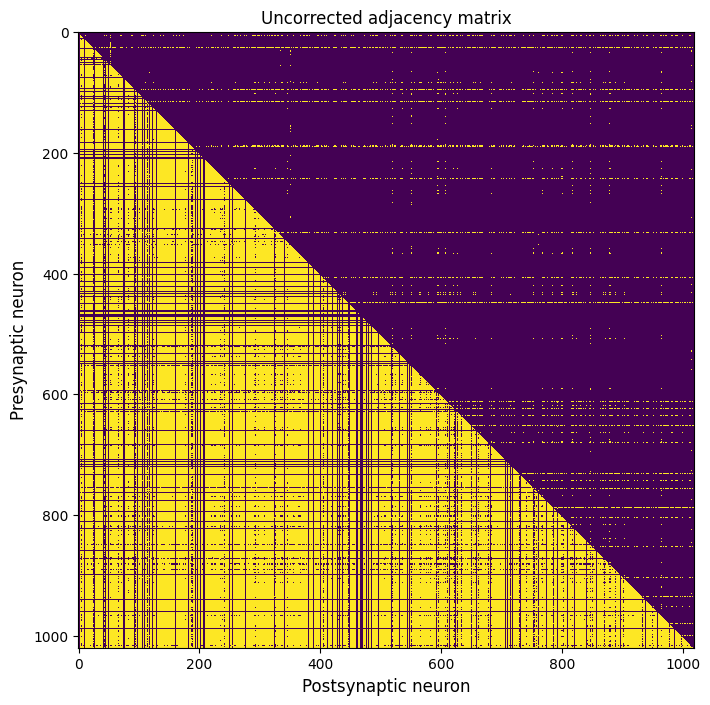

In [22]:
well = 'well001'
win = 'win_0'

adj_matrix = data[well][win]['adj_matrix_predicted']
print(sum(sum(adj_matrix)))
votes = data[well][win]['votes']
corr_peaks = data[well][win]['corr_peaks']

fontsize = 12
plt.figure(figsize=(8, 8))
plt.imshow(adj_matrix, interpolation='nearest')
plt.title('Uncorrected adjacency matrix', fontsize=fontsize)
plt.ylabel('Presynaptic neuron', fontsize=fontsize)
_ = plt.xlabel('Postsynaptic neuron', fontsize=fontsize)

## View a "corrected" adjacency matrix

Putative connections that are likely be due to a common or global source rather than causal from neuron to neuron, or removed.

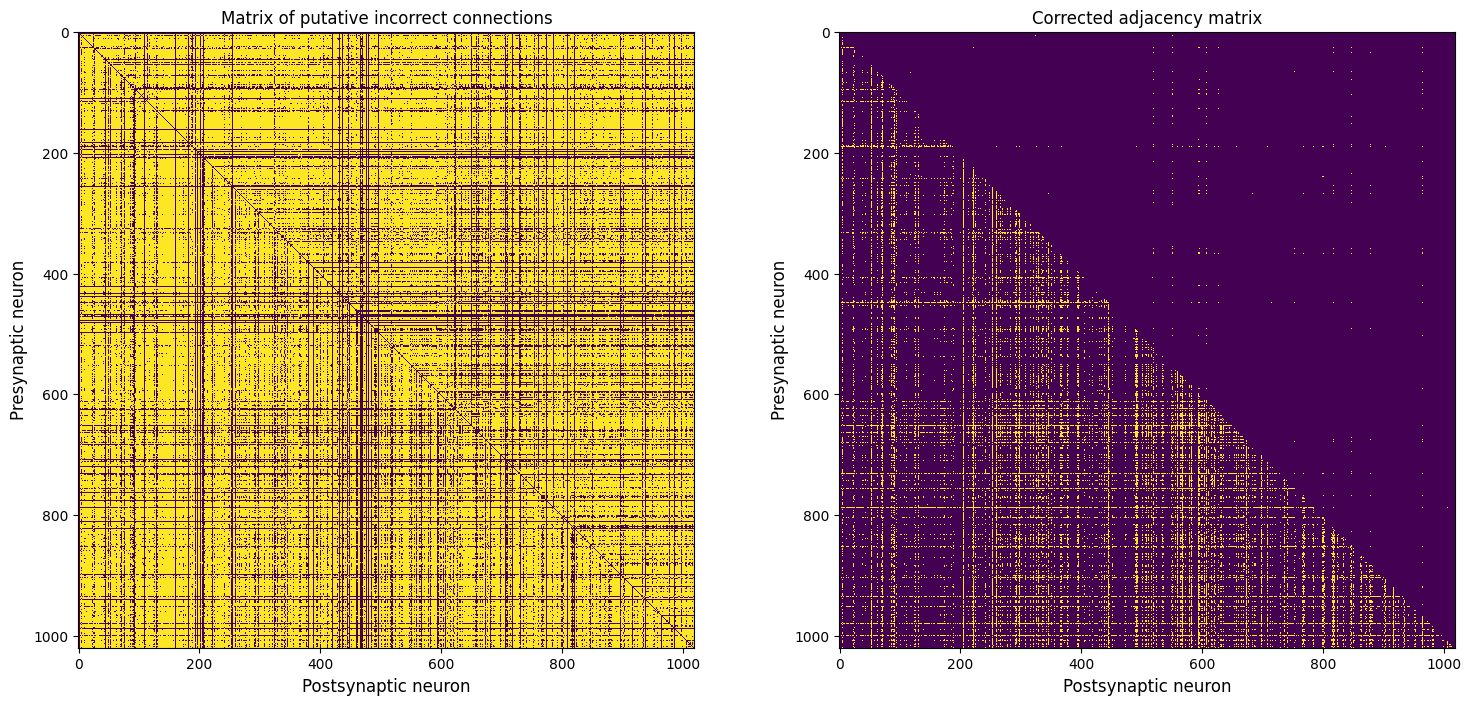

In [21]:
# Neurons pairs linked only by correlation peak delays lower than t_res may actually
# be simultaneously stimulated by some common/global source, rather than casually linked.
# We can identify those pairs and remove their link from the adjacency matrix if we'd like to.
synced_matrix = np.full(adj_matrix.shape, False)
for key in corr_peaks.keys():
    if np.all(np.abs(np.array(corr_peaks[key]['delays'])) < 1/data['config']['data']['fs']):
        synced_matrix[key[0], key[1]] = True
        synced_matrix[key[1], key[0]] = True
filtered_matrix = np.logical_and(data[well][win]['adj_matrix_predicted'], np.logical_not(synced_matrix))

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.imshow(synced_matrix, interpolation='nearest')
plt.title('Matrix of putative incorrect connections', fontsize=fontsize)
plt.ylabel('Presynaptic neuron', fontsize=fontsize)
plt.xlabel('Postsynaptic neuron', fontsize=fontsize)

plt.subplot(1, 2, 2)
plt.imshow(filtered_matrix, interpolation='nearest')
plt.title('Corrected adjacency matrix', fontsize=fontsize)
plt.ylabel('Presynaptic neuron', fontsize=fontsize)
_ = plt.xlabel('Postsynaptic neuron', fontsize=fontsize)

# View a "corrected" adjacency matrix in which unconnected neurons are moved from the matrix

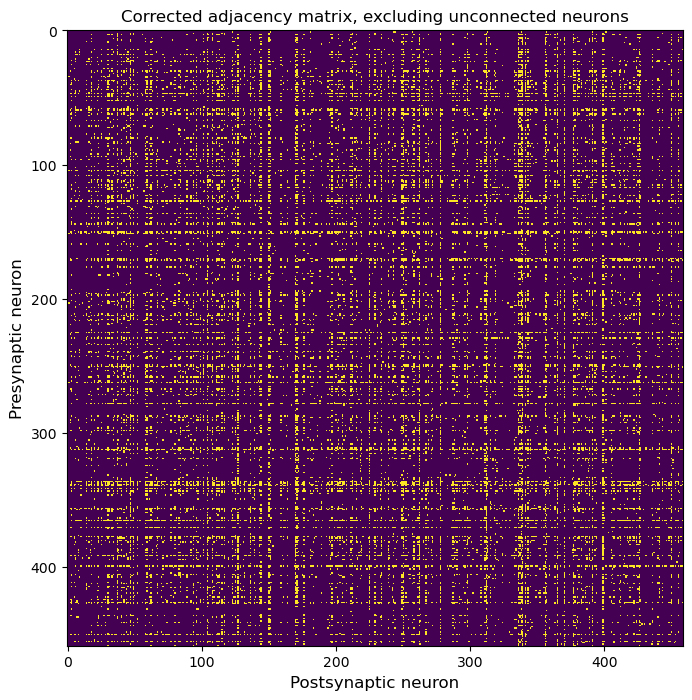

In [7]:
# Finally, let's remove the neurons that have no connections, and remove them.
ix_connected_col = np.argwhere(np.any(filtered_matrix>0, axis=0))[:, 0]
ix_connected_row = np.argwhere(np.any(filtered_matrix>0, axis=1))[:, 0]
ix_connected = np.union1d(ix_connected_col, ix_connected_row)
plt.figure(figsize=(8, 8))
plt.imshow(filtered_matrix[ix_connected][:, ix_connected], interpolation='nearest')
plt.title('Corrected adjacency matrix, excluding unconnected neurons', fontsize=fontsize)
plt.ylabel('Presynaptic neuron', fontsize=fontsize)
_ = plt.xlabel('Postsynaptic neuron', fontsize=fontsize)